# Improving the Graph

## Steps

* Get the contigs and calculate the coverage
    * Align the contigs to reads using Minimap2
    * Sort the aligments using Samtools
    * Obtain the dept of each contig position using Samtools depth

* Get the coverage of links in the graph
    * For each link, obtain the connection sequence by connecting the latter 50% of first contig with first 50% of the next contig
    * Obtain the coverage as in the same way above

## Extracting Contigs, Links and Connection Contigs from the GFA file

In [6]:
# All the imports
import gfapy as gf

# Python imports
from pathlib import Path
import re
import copy

# BioPython imports
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import DNAAlphabet
from Bio import SeqIO

# Scientific imports
import numpy as np
import matplotlib.pyplot as plt

# Predefined variables
readspath = "../Assembly/Sampled Reads/sd_0004.fastq"
# readspath = "../Assembly/Sampled Reads EColi/sd_0001.fastq"
graphpath = "/media/anuradhawick/data/Experiments/Assembly Graph/Assembly/FLYE/Out FLYE_4/assembly_graph.gfa"
# graphpath = "/media/anuradhawick/data/Experiments/Assembly Graph/Assembly/FLYE/Out EColi/assembly_graph.gfa"
read_coverage = 50
read_length = 10000

In [7]:
![ -e 'links' ] && rm -r 'links'
![ -e 'contigs' ] && rm -r 'contigs'
![ -e 'mappings' ] && rm -r 'mappings'

![ ! -e 'links' ] && mkdir 'links'
![ ! -e 'contigs' ] && mkdir 'contigs'
![ ! -e 'mappings' ] && mkdir 'mappings'

gfa = gf.Gfa.from_file(graphpath)

segments = {}
contig_lengths = {}

def get_aligning_sequences(s1, o1, s2, o2):
    seq1 = Seq(s1)
    seq2 = Seq(s2)

    if (o1 == '-'):
        seq1 = seq1.reverse_complement()
    
    if (o2 == '-'):
        seq2 = seq2.reverse_complement()

    return seq1, seq2

for x in gfa.segments:
    segments[x.name] = x
    contig_lengths[x.name] = len(x.sequence)
    record1 = SeqRecord(Seq(x.sequence, DNAAlphabet),
                        id=x.name, description="Contig name="+x.name)
    SeqIO.write(record1, "./contigs/" + x.name, "fasta")
    
    

for x in gfa.dovetails:
    seq1, seq2 = get_aligning_sequences(x.from_segment.sequence, x.from_orient, x.to_segment.sequence, x.to_orient)

    idstr = x.from_segment.name + x.from_orient + x.to_segment.name + x.to_orient
#   TODO check if we need to get half or a weighted amount considering the read lengths
    seq1_portion = round(read_length / 2)
    seq2_portion = round(read_length / 2)
    
    record = SeqRecord(seq1[-1*seq1_portion::] + seq2[0:seq2_portion],
                        id=idstr, description="")

    SeqIO.write(record, "./links/"+idstr, "fasta")


# Computing Coverage of Links and Contigs

## Function to Obtain Coverage of Contigs and Links

In [8]:
def compute_contig_coverage(folder):
    paths = Path(folder).glob('**/*')

    coverage_dict = {}

    for p in [str(p) for p in paths]:
        fname = p.split("/").pop()
        print("INFO::Inspecting path = " + p)

        !minimap2 -a "$p" "$readspath" > out.txt
        !samtools sort out.txt > out.sorted.txt
        !samtools depth out.sorted.txt > out.txt

        tot = !cut -f3 out.txt | paste -sd+ | bc
        lines = !wc -l out.txt

        tot = float(tot[0])
        lines = float(lines[0].split()[0])
        
        y = !cut -f3 out.txt        
        
        y = np.array(y)
        x = np.arange(len(y))
        
        plt.plot(x,y)
        plt.show()
        plt.figure()

        coverage = tot/lines
        !rm out.txt
        !rm out.sorted.txt

        coverage_dict[fname] = coverage
    return coverage_dict


def get_match_from_cigar(cigar):
    matches = re.findall(r'(\d+)M', cigar)
    misses = re.findall(r'(\d+)H', cigar)
    deletions = re.findall(r'(\d+)D', cigar)
    insertions = re.findall(r'(\d+)I', cigar)
    
    return sum(map(int, matches)), sum(map(int, misses)), sum(map(int, deletions)), sum(map(int, insertions))
    

def obtain_relevant_mappings(mapping_file, output_file, contig1_length, contig2_length):
    print ("INFO:: Filtering irrelavant maps")
    with open(output_file, 'w+') as outf:
        with open(mapping_file, 'r') as mapf:
            line_o = mapf.readline()
            line = line_o.split()
            # consume headers
            while line_o[0] == "@":
                outf.write(line_o)
                line_o = mapf.readline()
                line = line_o.split()
            while line_o:
                # mapping attributes
                pos = int(line[3])

                if pos == 0: 
                    line_o = mapf.readline()
                    line = line_o.split()
                    continue # no match found
                else:
                    # match found
                    matches, misses, deletions, insertions = get_match_from_cigar(line[5])
                    
                    # ensure mappings including both links are taken (half of a read lenth overlap)
                    match_starts_contig1 = (pos-1) < contig1_length * 0.75
                    match_ends_contig2 = sum([matches, misses, deletions, insertions]) + pos > contig1_length + contig2_length * 0.25

                    # if matches are from both links it is a valid mapping
                    if match_starts_contig1 and match_ends_contig2: # and matches / (matches + misses + deletions + insertions) > 0.9:
                        outf.write(line_o)
                
                line_o = mapf.readline()
                line = line_o.split()
    print ("INFO:: Done filtering irrelavant maps")
    
    
def get_contig_names_from_file_name(fname):
    content = re.split('\+|\-',fname)
    valid_content = []
    
    for x in content:
        if len(x.strip()) > 0:
            valid_content.append(x.strip())
    
    return valid_content
    
    
def compute_link_coverage(folder, read_coverage=50):
    paths = Path(folder).glob('**/*')

    coverage_dict = {}

    for p in [str(p) for p in paths]:
        fname = p.split("/").pop()
        
        c1_len = round(read_length / 2)
        c2_len = round(read_length / 2)        
        
        print("INFO::Inspecting link = " + p)

        !minimap2 -a "$p" "$readspath" > unfiltered.out.txt
        
        obtain_relevant_mappings('unfiltered.out.txt', 'filtered.out.txt', c1_len, c2_len)
                
        !samtools sort filtered.out.txt > filtered.out.sorted.txt
        
        basewise_coverage = !samtools depth filtered.out.sorted.txt
        
        data = [int(x.split()[2]) for x in basewise_coverage]
        npd = np.array(data)

        n, bins, patches = plt.hist(x=npd, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
        plt.grid(axis='y', alpha=0.75)
        plt.xlabel('Coverage')
        plt.ylabel('Occurances')
        plt.title('Coverage Distribution')
        maxfreq = n.max()
        # Set a clean upper y-axis limit.
        plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
        plt.show()
        plt.figure()
        if len(npd) > 0:
            mean = npd.mean()# because we consider half's coverage for the whole contigs (correction)
            std = npd.std()
        else:
            mean, std = 0, 0
        
        print("Mean", mean, "Std", std)

        !rm unfiltered.out.txt
        !rm filtered.out.txt
        !rm filtered.out.sorted.txt

        coverage_dict[fname] = mean
    return coverage_dict

## Obtaining Coverage of Links

INFO::Inspecting path = contigs/contig_3
[M::mm_idx_gen::0.052*1.02] collected minimizers
[M::mm_idx_gen::0.063*1.36] sorted minimizers
[M::main::0.063*1.36] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.068*1.34] mid_occ = 3
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.071*1.32] distinct minimizers: 372580 (99.87% are singletons); average occurrences: 1.001; average spacing: 5.361
[M::worker_pipeline::9.108*2.78] mapped 19193 sequences
[M::main] Version: 2.14-r886-dirty
[M::main] CMD: minimap2 -a contigs/contig_3 ../Assembly/Sampled Reads/sd_0004.fastq
[M::main] Real time: 9.112 sec; CPU: 25.352 sec; Peak RSS: 0.495 GB


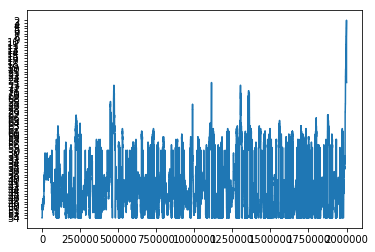

INFO::Inspecting path = contigs/contig_2
[M::mm_idx_gen::0.069*1.03] collected minimizers
[M::mm_idx_gen::0.078*1.25] sorted minimizers
[M::main::0.078*1.25] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.082*1.24] mid_occ = 3
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.085*1.23] distinct minimizers: 326069 (99.89% are singletons); average occurrences: 1.001; average spacing: 5.361
[M::worker_pipeline::9.518*2.77] mapped 19193 sequences
[M::main] Version: 2.14-r886-dirty
[M::main] CMD: minimap2 -a contigs/contig_2 ../Assembly/Sampled Reads/sd_0004.fastq
[M::main] Real time: 9.537 sec; CPU: 26.389 sec; Peak RSS: 0.504 GB


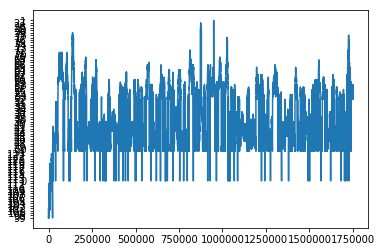

INFO::Inspecting path = contigs/contig_1
[M::mm_idx_gen::0.036*1.04] collected minimizers
[M::mm_idx_gen::0.045*1.40] sorted minimizers
[M::main::0.045*1.40] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.047*1.39] mid_occ = 3
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.048*1.38] distinct minimizers: 116381 (99.95% are singletons); average occurrences: 1.001; average spacing: 5.368
[M::worker_pipeline::6.774*2.72] mapped 19193 sequences
[M::main] Version: 2.14-r886-dirty
[M::main] CMD: minimap2 -a contigs/contig_1 ../Assembly/Sampled Reads/sd_0004.fastq
[M::main] Real time: 6.776 sec; CPU: 18.418 sec; Peak RSS: 0.481 GB


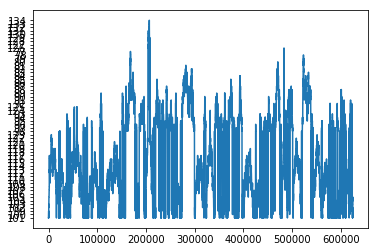

INFO::Inspecting link = links/contig_1+contig_1+
[M::mm_idx_gen::0.001*1.66] collected minimizers
[M::mm_idx_gen::0.002*2.13] sorted minimizers
[M::main::0.002*2.13] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.002*2.06] mid_occ = 2
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.002*2.01] distinct minimizers: 1876 (100.00% are singletons); average occurrences: 1.000; average spacing: 5.330
[M::worker_pipeline::2.453*2.27] mapped 19193 sequences
[M::main] Version: 2.14-r886-dirty
[M::main] CMD: minimap2 -a links/contig_1+contig_1+ ../Assembly/Sampled Reads/sd_0004.fastq
[M::main] Real time: 2.453 sec; CPU: 5.568 sec; Peak RSS: 0.488 GB
INFO:: Filtering irrelavant maps
INFO:: Done filtering irrelavant maps


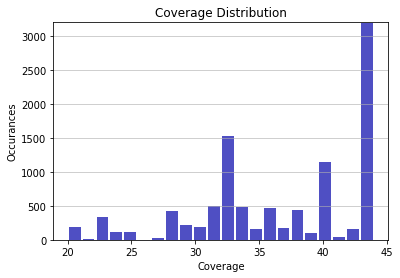

Mean 36.6623 Std 6.618569234358737
INFO::Inspecting link = links/contig_2-contig_3+
[M::mm_idx_gen::0.001*1.85] collected minimizers
[M::mm_idx_gen::0.001*2.17] sorted minimizers
[M::main::0.001*2.16] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.002*2.05] mid_occ = 2
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.002*2.00] distinct minimizers: 1848 (100.00% are singletons); average occurrences: 1.000; average spacing: 5.411
[M::worker_pipeline::2.464*2.24] mapped 19193 sequences
[M::main] Version: 2.14-r886-dirty
[M::main] CMD: minimap2 -a links/contig_2-contig_3+ ../Assembly/Sampled Reads/sd_0004.fastq
[M::main] Real time: 2.465 sec; CPU: 5.509 sec; Peak RSS: 0.489 GB
INFO:: Filtering irrelavant maps
INFO:: Done filtering irrelavant maps


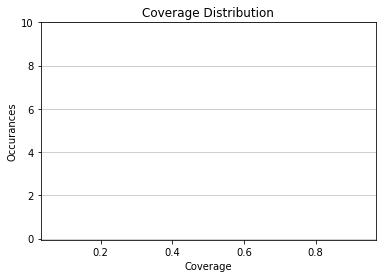

Mean 0 Std 0
INFO::Inspecting link = links/contig_1+contig_3+
[M::mm_idx_gen::0.001*1.77] collected minimizers
[M::mm_idx_gen::0.002*2.18] sorted minimizers
[M::main::0.002*2.18] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.002*2.11] mid_occ = 2
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.002*2.06] distinct minimizers: 1841 (100.00% are singletons); average occurrences: 1.000; average spacing: 5.432
[M::worker_pipeline::2.480*2.26] mapped 19193 sequences
[M::main] Version: 2.14-r886-dirty
[M::main] CMD: minimap2 -a links/contig_1+contig_3+ ../Assembly/Sampled Reads/sd_0004.fastq
[M::main] Real time: 2.480 sec; CPU: 5.604 sec; Peak RSS: 0.481 GB
INFO:: Filtering irrelavant maps
INFO:: Done filtering irrelavant maps


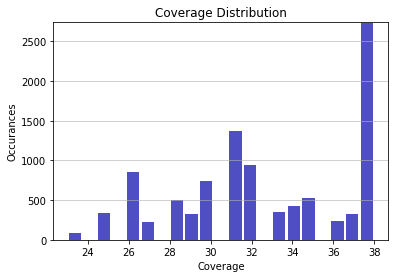

Mean 32.6507 Std 4.34109312385717
INFO::Inspecting link = links/contig_2-contig_1+
[M::mm_idx_gen::0.001*1.80] collected minimizers
[M::mm_idx_gen::0.002*2.24] sorted minimizers
[M::main::0.002*2.23] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.002*2.16] mid_occ = 2
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.002*2.10] distinct minimizers: 1885 (100.00% are singletons); average occurrences: 1.000; average spacing: 5.305
[M::worker_pipeline::2.490*2.25] mapped 19193 sequences
[M::main] Version: 2.14-r886-dirty
[M::main] CMD: minimap2 -a links/contig_2-contig_1+ ../Assembly/Sampled Reads/sd_0004.fastq
[M::main] Real time: 2.491 sec; CPU: 5.609 sec; Peak RSS: 0.491 GB
INFO:: Filtering irrelavant maps
INFO:: Done filtering irrelavant maps


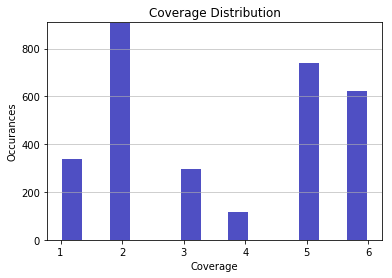

Mean 3.6192523982798543 Std 1.7987351301075987
{'contig_1+contig_1+': 36.6623, 'contig_2-contig_3+': 0, 'contig_1+contig_3+': 32.6507, 'contig_2-contig_1+': 3.6192523982798543}

{'contig_3': 48.824345946075674, 'contig_2': 51.54790862465534, 'contig_1': 102.2143936}
Link coverages after removal of insignificant links
{'contig_1+contig_1+': 36.6623, 'contig_1+contig_3+': 32.6507, 'contig_2-contig_1+': 3.6192523982798543}



<Figure size 432x288 with 0 Axes>

In [10]:
# Running Coverage Calculation for Contigs

contig_coverage = compute_contig_coverage("./contigs/")
# # contig_coverage = {   'c2': 50,
# #     'c1': 150,
# #     'c3': 49,
# #     'c4': 50
# #     }

link_coverage = compute_link_coverage("./links/")
# link_coverage = {   'c2+c1+': 50,
#     'c1+c1+': 100,
#     'c1+c3+': 53,
#     'c3+c4': 50}

print(link_coverage)
print()
print(contig_coverage)

for key in list(link_coverage.keys()):
    if link_coverage[key] == 0:
        del link_coverage[key]
        
print("Link coverages after removal of insignificant links")
print(link_coverage)
print()

# Functions to resolve links.
The following functions are used to resolve links and obtain the graph presentation
```
TODO

```

In [21]:
# resolution of significant link cycles
# detect the cycle
#    get the coverage for link
#    if the link_coverage = read_covereage => contig x 2 and so on as it becomes multiples
#    contiguous occurances of the contig = link_coverage/read_coverage + 1
def name_decomposer(link_name):
    decomposed = []
    temp = ""
    
    for c in link_name:
        if c == "+" or c == "-":
            contig_name = temp
            temp = ""
            decomposed.extend([contig_name, c])
        else: temp += c
    return decomposed


def round_to_coverage(x, base=read_coverage):
    return int(base * round(float(x)/base))


def get_possible_arrangements(contig_repeats_count, link_repeat_count):
    if contig_repeats_count == link_repeat_count: return 0
    elif contig_repeats_count - link_repeat_count == 1 or link_repeat_count == 1: return 1
    
    partition_1 = [2 , 1]
    partition_2 = [contig_repeats_count - 2, link_repeat_count - 1]
    
    combined_p1_p2 = get_possible_arrangements(partition_1[0] + 1, partition_1[1] + 1)
    alone_p2 = get_possible_arrangements(partition_2[0], partition_2[1])
    
    return combined_p1_p2 + alone_p2


def is_cycle(link_name):
    names = name_decomposer(link_name)
    
    return names[0] == names[2] and names[1] == names[3]


def index_links(links_array):
    next_contigs_index = {}
    previous_contigs_index = {}
    
    for link in links_array:
        link_content = name_decomposer(link)
        
        from_link = "".join(link_content[0:2])
        to_link = "".join(link_content[2:4])
        
        if not from_link in next_contigs_index:
            next_contigs_index[from_link] = [to_link]
        else:
            next_contigs_index[from_link].append(to_link)
        
        if not to_link in previous_contigs_index:
            previous_contigs_index[to_link] = [from_link]
        else:
            previous_contigs_index[to_link].append(from_link)
    return next_contigs_index, previous_contigs_index


def normalize_links(links_array):
    normalized_array = []
    
    for link in links_array:
        link_content = name_decomposer(link)
        
        if link_content[1] == '+':
            normalized_array.append(link)
        elif link_content[1] == '-' and link_content[3] == '-':
            link_content[0], link_content[2] = link_content[2], link_content[0]
            link_content[1] = '+'
            link_content[3] = '+'
            normalized_array.append("".join(link_content))
        else:
            # cannot change anymore
            normalized_array.append(link)
    return normalized_array
            

# mark unique contigs and connections along with their coverage:read_coverage ratio i.e. repetitions
# def linkage_compressor(links_array):
    
#     for link in links_array
    
# operates with a string array
def resolve_links(links_array):
    links_array = normalize_links(links_array)
    linked_contigs = {}
    cycles = {}
    resolved_links = []
    next_contigs_index, previous_contigs_index = index_links(links_array)
    
    # one pass detection of cycles
    
    for link in links_array:
        # indexing discovered contigs
        name_content = name_decomposer(link)
        contig_names = name_content[::2]
        contig_orientations = name_content[1::2]
        
        # to mark contigs that are covered in links i.e. contigs possible in the genome
        linked_contigs[contig_names[0]] = True
        linked_contigs[contig_names[1]] = True
        
        
        # if not cycle directly append the link
        if not is_cycle(link): 
            resolved_links.append(link)
            continue
            
        link_repeats = round_to_coverage(link_coverage[link]) / read_coverage
        contig_repeats = round_to_coverage(contig_coverage[contig_names[0]]) / read_coverage
        
        possible_solutions = get_possible_arrangements(contig_repeats, link_repeats)
        
        # there is only one solution if only 1 arrangement possible 
        if possible_solutions == 1:
#             resolved_links.append((contig_names[0] + contig_orientations[0]) * (1 + int(link_repeats)))
            cycles.append((contig_names[0] + contig_orientations[0]) * (1 + int(link_repeats)))
        else:
            # TODO generate the algebraic expression here
            print ("conflict", possible_solutions, contig_repeats, link_repeats)
            
    return resolved_links, cycles, linked_contigs

## Resolve links and obtain the genome expression

In [ ]:
# get rid of clycles by connecting to neighbours
# def connect_links(links, cycles, contigs=None):
print(normalize_links(list(link_coverage.keys())))
print(index_links(normalize_links(list(link_coverage.keys()))))